
# Practical PID Controller — Saturation, Anti‑Windup, Noise & Disturbance

**Date:** 2025-09-03

This notebook extends the basic PID with **actuator limits, anti‑windup, derivative on measurement with filtering, measurement noise, and disturbances**. It’s designed for classroom demos and exploration with sliders.


In [1]:
# Versions (optional)
import sys
print("Python:", sys.version)
try:
    import ipywidgets as widgets; print("ipywidgets:", widgets.__version__)
except Exception as e:
    print("ipywidgets not available:", e)
try:
    import numpy as np; import matplotlib; import matplotlib.pyplot as plt
    print("numpy:", np.__version__); print("matplotlib:", matplotlib.__version__)
except Exception as e:
    print("Scientific stack check issue:", e)

# Plot defaults
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (9, 4)
plt.rcParams['axes.grid'] = True

Python: 3.12.12 | packaged by conda-forge | (main, Jan 27 2026, 00:01:15) [Clang 19.1.7 ]
ipywidgets: 8.1.8
numpy: 2.4.1
matplotlib: 3.10.8



## Control Loop Structure (with Disturbance)

```mermaid
flowchart TD
  S[Setpoint r] --> CMP((⊖))
  Y -.-> CMP
  CMP -->|Error e = r - y_meas| C[PID Controller]
  C --> U[Controller output u]
  U --> SUM((⊕))
  D[Disturbance d] --> SUM
  SUM --> P[Plant / Process]
  P --> Y[Process output y]
  Y -. Measured output y_meas .-> CMP

classDef cmp fill=#fdf,stroke=#333,stroke-width=1px;
classDef sum fill=#dfd,stroke=#333,stroke-width=1px;
```



## Plant model (first‑order + disturbance)

We use a first‑order system without explicit delay, with input disturbance:
$$
\tau \dot{y}(t) = -y(t) + K \, \big(u(t) + d(t)\big)
$$

- \( y(t) \): process output  
- \( u(t) \): controller output (actuator command)  
- \( d(t) \): disturbance at the plant input  
- \( K \): plant gain, \( \tau \): time constant


In [2]:
from dataclasses import dataclass
import numpy as np

@dataclass
class FirstOrderPlantCfg:
    K: float = 1.0
    tau: float = 0.5
    dt: float = 0.01
    y0: float = 0.0

class FirstOrderPlant:
    def __init__(self, cfg: FirstOrderPlantCfg):
        self.cfg = cfg
        self.y = cfg.y0

    def reset(self, y0=0.0):
        self.y = y0

    def step(self, controller_output, disturbance_input=0.0):
        # Euler integration of tau*dy = -y + K*(u + d)
        dy = (-self.y + self.cfg.K * (controller_output + disturbance_input)) / self.cfg.tau
        self.y += self.cfg.dt * dy
        return self.y


## Robust PID controller (discrete)

Features:
- **Derivative on measurement** (less sensitive to setpoint steps)
- **Derivative filter** (first‑order, time constant \( \tau_D \))
- **Actuator saturation** \( u_{\min} \le u \le u_{\max} \)
- **Anti‑windup**: *off*, *clamping*, or *back‑calculation* (\(K_{aw}\))


In [3]:
@dataclass
class RobustPIDConfig:
    proportional_gain: float = 2.0   # Kp
    integral_gain: float = 1.2       # Ki
    derivative_gain: float = 0.4     # Kd
    sample_time_s: float = 0.01      # dt
    derivative_filter_tau_s: float = 0.05  # tau_D for derivative low-pass (on measurement)
    output_min: float = -2.0         # saturation min
    output_max: float =  2.0         # saturation max
    antiwindup_method: str = "clamp" # 'off' | 'clamp' | 'backcalc'
    backcalc_gain_kaw: float = 5.0   # back-calculation gain (if used)
    derivative_clip: float = 200.0   # safety clamp for derivative term

class RobustPID:
    """PID with derivative on measurement, filtering, saturation, anti-windup."""
    def __init__(self, cfg: RobustPIDConfig):
        self.cfg = cfg
        self.integral_state = 0.0
        self.prev_meas_filt = 0.0
        self.prev_output_unsat = 0.0

    def reset(self):
        self.integral_state = 0.0
        self.prev_meas_filt = 0.0
        self.prev_output_unsat = 0.0

    def step(self, setpoint, measured_output):
        dt = max(1e-9, self.cfg.sample_time_s)

        # Proportional term on error
        error = setpoint - measured_output
        P = self.cfg.proportional_gain * error

        # Integral (tentative update)
        I_candidate = self.integral_state + self.cfg.integral_gain * dt * error

        # Derivative on measurement with 1st-order low-pass
        tauD = max(1e-6, self.cfg.derivative_filter_tau_s)
        beta = dt / (tauD + dt)  # 0..1
        meas_filt = (1 - beta) * self.prev_meas_filt + beta * measured_output
        d_meas = (meas_filt - self.prev_meas_filt) / dt
        D_meas = self.cfg.derivative_gain * d_meas
        if self.cfg.derivative_clip and self.cfg.derivative_clip > 0:
            D_meas = float(np.clip(D_meas, -self.cfg.derivative_clip, self.cfg.derivative_clip))

        # Unsaturated controller output: note the minus sign for D(measurement)
        u_unsat = P + I_candidate - D_meas

        # Apply saturation
        u_sat = max(self.cfg.output_min, min(self.cfg.output_max, u_unsat))

        # Anti-windup
        if self.cfg.antiwindup_method == "off":
            self.integral_state = I_candidate
        elif self.cfg.antiwindup_method == "clamp":
            # If saturated and I would push further into saturation, freeze I
            pushing_high = (u_unsat > self.cfg.output_max) and (I_candidate > self.integral_state)
            pushing_low  = (u_unsat < self.cfg.output_min) and (I_candidate < self.integral_state)
            if not (pushing_high or pushing_low):
                self.integral_state = I_candidate
        else:  # backcalc
            aw = self.cfg.backcalc_gain_kaw * (u_sat - u_unsat)
            self.integral_state = I_candidate + aw * dt

        # Update memory
        self.prev_meas_filt = meas_filt
        self.prev_output_unsat = u_unsat

        return u_sat, error


## Closed‑loop simulation (with disturbance & noise)

We simulate unity feedback with measurement noise \(n(t)\) and scheduled setpoint/disturbance steps.


In [4]:
def simulate_closed_loop_robust(pid_cfg: RobustPIDConfig,
                                plant_cfg: FirstOrderPlantCfg,
                                duration_s=6.0,
                                setpoint_schedule=((0.0, 0.0), (0.5, 1.0), (3.0, 0.5)),
                                disturbance_schedule=((2.0, 0.3),),
                                noise_std=0.0):
    dt = pid_cfg.sample_time_s
    n_steps = int(duration_s / dt)
    time_s = np.arange(n_steps) * dt

    setpoint = np.zeros(n_steps)
    for t_switch, sp_value in setpoint_schedule:
        setpoint[time_s >= t_switch] = sp_value

    disturbance_input = np.zeros(n_steps)
    for t_switch, d_value in disturbance_schedule:
        disturbance_input[time_s >= t_switch] = d_value

    plant = FirstOrderPlant(plant_cfg)
    controller = RobustPID(pid_cfg)

    process_output = np.zeros(n_steps)
    measured_output = np.zeros(n_steps)
    controller_output = np.zeros(n_steps)
    error_signal = np.zeros(n_steps)

    for k in range(n_steps):
        noise = np.random.normal(0.0, noise_std) if noise_std > 0 else 0.0
        measured_output[k] = plant.y + noise
        controller_output[k], error_signal[k] = controller.step(setpoint[k], measured_output[k])
        process_output[k] = plant.step(controller_output[k], disturbance_input=disturbance_input[k])

    return time_s, setpoint, process_output, measured_output, controller_output, error_signal, disturbance_input


## Widget Test

Run this quick test—if you see a real slider below, widgets are enabled in your Jupyter.  
If you only see `<IntSlider>`, install/enable widgets (see earlier instructions).

In [5]:
import ipywidgets as widgets
widgets.IntSlider(description="Test slider")

IntSlider(value=0, description='Test slider')


## Interactive Playground (Robust PID)

Use the sliders to tune the controller and observe saturation, anti‑windup behavior, and noise sensitivity.
If widgets do not appear, install `ipywidgets` and `jupyterlab_widgets` in your environment.


In [6]:
try:
    import ipywidgets as widgets
    from IPython.display import display, clear_output

    # Use distinct names to avoid collisions with floats in the namespace
    Kp_w = widgets.FloatSlider(description='Kp', value=2.0, min=0.0, max=10.0, step=0.1)
    Ki_w = widgets.FloatSlider(description='Ki', value=1.2, min=0.0, max=10.0, step=0.1)
    Kd_w = widgets.FloatSlider(description='Kd', value=0.4, min=0.0, max=3.0, step=0.05)
    tauD_w = widgets.FloatSlider(description='D filter τ [s]', value=0.05, min=0.0, max=0.5, step=0.005)

    umin_w = widgets.FloatSlider(description='u_min', value=-2.0, min=-10.0, max=0.0, step=0.1)
    umax_w = widgets.FloatSlider(description='u_max', value= 2.0, min= 0.0,  max=10.0, step=0.1)

    aw_method_w = widgets.Dropdown(description='Anti-windup', options=[('off','off'),('clamp','clamp'),('backcalc','backcalc')], value='clamp')
    kaw_w = widgets.FloatSlider(description='Kaw (backcalc)', value=5.0, min=0.0, max=30.0, step=0.5)

    noise_std_w = widgets.FloatSlider(description='noise std', value=0.05, min=0.0, max=0.3, step=0.005)
    dist_amp_w  = widgets.FloatSlider(description='disturbance', value=0.3, min=-1.0, max=1.0, step=0.05)
    dist_time_w = widgets.FloatSlider(description='dist time [s]', value=2.0, min=0.0, max=10.0, step=0.1)

    duration_w = widgets.FloatSlider(description='duration [s]', value=6.0, min=2.0, max=20.0, step=0.5)
    dt_w       = widgets.FloatSlider(description='dt [s]', value=0.01, min=0.002, max=0.05, step=0.001)

    controls = widgets.VBox([
        widgets.HBox([Kp_w, Ki_w, Kd_w, tauD_w]),
        widgets.HBox([umin_w, umax_w, aw_method_w, kaw_w]),
        widgets.HBox([noise_std_w, dist_amp_w, dist_time_w]),
        widgets.HBox([duration_w, dt_w]),
    ])

    out = widgets.Output()

    def run_sim(*_):
        with out:
            clear_output(wait=True)
            # Read .value from widgets (robust to accidental shadowing)
            Kp_v, Ki_v, Kd_v = float(getattr(Kp_w, "value", Kp_w)), float(getattr(Ki_w, "value", Ki_w)), float(getattr(Kd_w, "value", Kd_w))
            tauD_v = float(getattr(tauD_w, "value", tauD_w))
            umin_v, umax_v = float(getattr(umin_w, "value", umin_w)), float(getattr(umax_w, "value", umax_w))
            aw_method_v = getattr(aw_method_w, "value", aw_method_w)
            kaw_v = float(getattr(kaw_w, "value", kaw_w))
            noise_v = float(getattr(noise_std_w, "value", noise_std_w))
            dist_amp_v = float(getattr(dist_amp_w, "value", dist_amp_w))
            dist_time_v = float(getattr(dist_time_w, "value", dist_time_w))
            duration_v = float(getattr(duration_w, "value", duration_w))
            dt_v = float(getattr(dt_w, "value", dt_w))

            pid_cfg = RobustPIDConfig(
                proportional_gain=Kp_v, integral_gain=Ki_v, derivative_gain=Kd_v,
                sample_time_s=dt_v, derivative_filter_tau_s=tauD_v,
                output_min=umin_v, output_max=umax_v,
                antiwindup_method=aw_method_v, backcalc_gain_kaw=kaw_v
            )
            plant_cfg = FirstOrderPlantCfg(K=1.0, tau=0.5, dt=dt_v)
            t, sp, y, y_meas, u, e, d = simulate_closed_loop_robust(
                pid_cfg, plant_cfg, duration_s=duration_v,
                setpoint_schedule=((0.0, 0.0), (0.5, 1.0), (3.0, 0.5)),
                disturbance_schedule=((dist_time_v, dist_amp_v),),
                noise_std=noise_v
            )

            import matplotlib.pyplot as plt
            # Plot 1
            plt.figure(figsize=(10,4))
            plt.plot(t, sp, label='Setpoint')
            plt.plot(t, y, label='Process output')
            plt.plot(t, y_meas, label='Measured output', alpha=0.6)
            plt.ylabel('Output'); plt.xlabel('Time [s]'); plt.legend(); plt.grid(True)
            plt.show()
            # Plot 2
            plt.figure(figsize=(10,4))
            plt.plot(t, u, label='Controller output')
            plt.axhline(umin_v, linestyle='--', alpha=0.6)
            plt.axhline(umax_v, linestyle='--', alpha=0.6)
            plt.ylabel('Controller output'); plt.xlabel('Time [s]'); plt.legend(); plt.grid(True)
            plt.show()
            # Plot 3
            plt.figure(figsize=(10,4))
            plt.plot(t, e, label='Error signal')
            plt.plot(t, d, label='Disturbance', alpha=0.7)
            plt.ylabel('Error / Disturbance'); plt.xlabel('Time [s]'); plt.legend(); plt.grid(True)
            plt.show()

    # Bind
    for w in [Kp_w, Ki_w, Kd_w, tauD_w, umin_w, umax_w, aw_method_w, kaw_w, noise_std_w, dist_amp_w, dist_time_w, duration_w, dt_w]:
        w.observe(run_sim, names='value')

    display(controls, out)
    run_sim()

except Exception as exc:
    print("ipywidgets not available or failed to initialize. Install ipywidgets and jupyterlab_widgets.")
    print("Error:", exc)

Output()


## Demonstrations

### A. Saturation & Anti‑Windup
Compare behavior **with** and **without** anti‑windup under tight actuator limits.


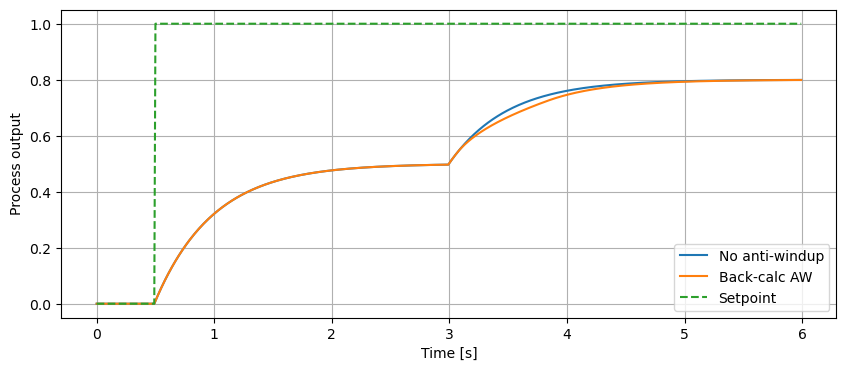

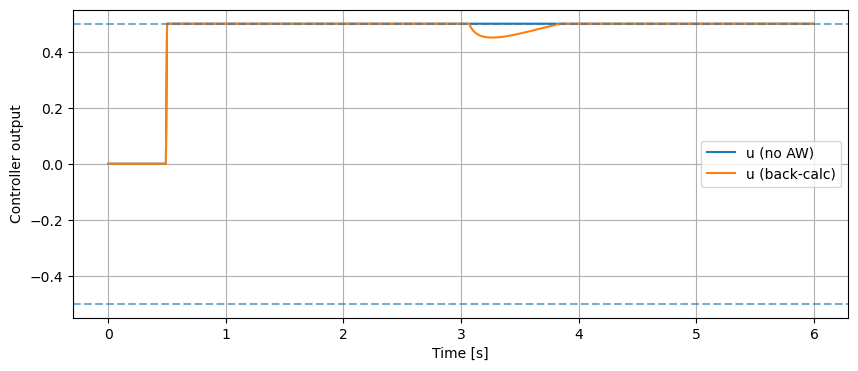

In [7]:
# Anti-windup comparison
pid_no_aw = RobustPIDConfig(proportional_gain=3.0, integral_gain=2.0, derivative_gain=0.1,
                            sample_time_s=0.01, derivative_filter_tau_s=0.05,
                            output_min=-0.5, output_max=0.5, antiwindup_method='off')
pid_backcalc = RobustPIDConfig(proportional_gain=3.0, integral_gain=2.0, derivative_gain=0.1,
                               sample_time_s=0.01, derivative_filter_tau_s=0.05,
                               output_min=-0.5, output_max=0.5, antiwindup_method='backcalc', backcalc_gain_kaw=8.0)

plant_cfg = FirstOrderPlantCfg(K=1.0, tau=0.5, dt=0.01)

t1, sp1, y1, y1m, u1, e1, d1 = simulate_closed_loop_robust(pid_no_aw, plant_cfg, duration_s=6.0,
                                                           setpoint_schedule=((0.0,0.0),(0.5,1.0)),
                                                           disturbance_schedule=((3.0,0.3),),
                                                           noise_std=0.0)
t2, sp2, y2, y2m, u2, e2, d2 = simulate_closed_loop_robust(pid_backcalc, plant_cfg, duration_s=6.0,
                                                           setpoint_schedule=((0.0,0.0),(0.5,1.0)),
                                                           disturbance_schedule=((3.0,0.3),),
                                                           noise_std=0.0)

# Plot outputs
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.plot(t1, y1, label='No anti-windup')
plt.plot(t2, y2, label='Back-calc AW')
plt.plot(t2, sp2, '--', label='Setpoint')
plt.ylabel('Process output'); plt.xlabel('Time [s]'); plt.legend(); plt.grid(True)
plt.show()

# Plot controller outputs
plt.figure(figsize=(10,4))
plt.plot(t1, u1, label='u (no AW)')
plt.plot(t2, u2, label='u (back-calc)')
plt.axhline(pid_backcalc.output_max, linestyle='--', alpha=0.6)
plt.axhline(pid_backcalc.output_min, linestyle='--', alpha=0.6)
plt.ylabel('Controller output'); plt.xlabel('Time [s]'); plt.legend(); plt.grid(True)
plt.show()


### B. Measurement Noise & Derivative Filtering
Increase noise and compare small vs large derivative filter time constant \( \tau_D \).


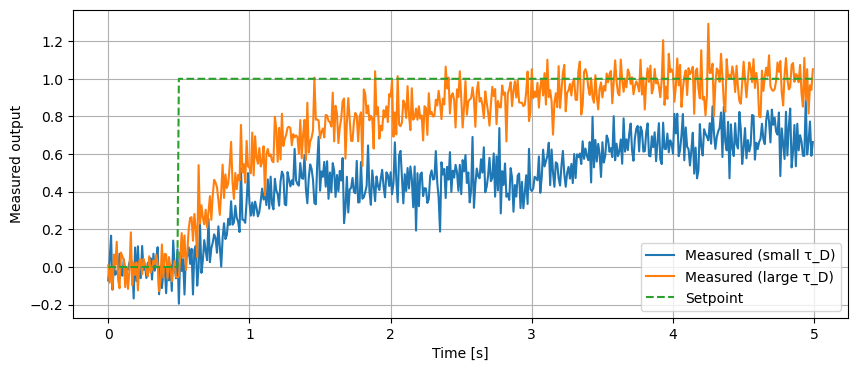

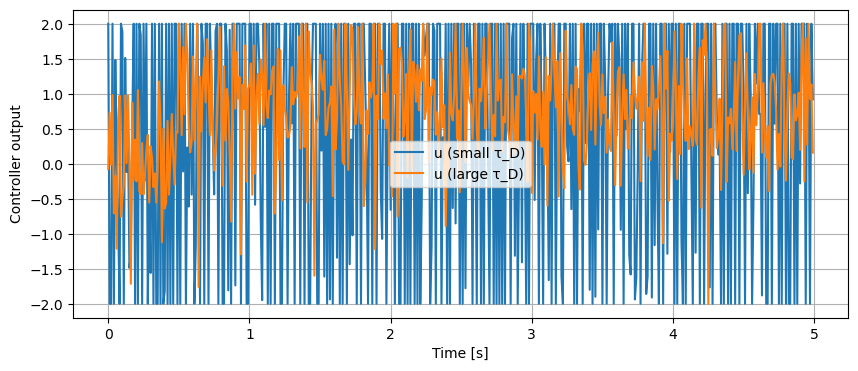

In [8]:
pid_small_tau = RobustPIDConfig(proportional_gain=2.0, integral_gain=1.2, derivative_gain=0.6,
                                sample_time_s=0.01, derivative_filter_tau_s=0.005,
                                output_min=-2.0, output_max=2.0, antiwindup_method='clamp')
pid_large_tau = RobustPIDConfig(proportional_gain=2.0, integral_gain=1.2, derivative_gain=0.6,
                                sample_time_s=0.01, derivative_filter_tau_s=0.08,
                                output_min=-2.0, output_max=2.0, antiwindup_method='clamp')

plant_cfg = FirstOrderPlantCfg(K=1.0, tau=0.5, dt=0.01)

tA, spA, yA, yAm, uA, eA, dA = simulate_closed_loop_robust(pid_small_tau, plant_cfg, duration_s=5.0,
                                                           setpoint_schedule=((0.0,0.0),(0.5,1.0)),
                                                           disturbance_schedule=((3.0,0.2),),
                                                           noise_std=0.08)

tB, spB, yB, yBm, uB, eB, dB = simulate_closed_loop_robust(pid_large_tau, plant_cfg, duration_s=5.0,
                                                           setpoint_schedule=((0.0,0.0),(0.5,1.0)),
                                                           disturbance_schedule=((3.0,0.2),),
                                                           noise_std=0.08)

import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.plot(tA, yAm, label='Measured (small τ_D)')
plt.plot(tB, yBm, label='Measured (large τ_D)')
plt.plot(tA, spA, '--', label='Setpoint')
plt.ylabel('Measured output'); plt.xlabel('Time [s]'); plt.legend(); plt.grid(True)
plt.show()

plt.figure(figsize=(10,4))
plt.plot(tA, uA, label='u (small τ_D)')
plt.plot(tB, uB, label='u (large τ_D)')
plt.ylabel('Controller output'); plt.xlabel('Time [s]'); plt.legend(); plt.grid(True)
plt.show()


## (Optional) Frequency‑domain intuition (`python-control`)

If the `control`/`python-control` package is available, the following cell shows open‑loop Bode and closed‑loop step for an *idealized* continuous‑time PID and the first‑order plant. This is for intuition; our simulation is discrete‑time.


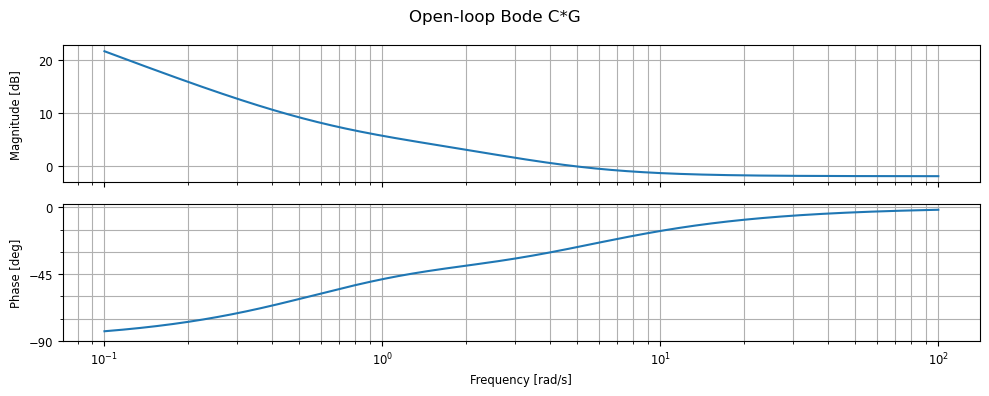

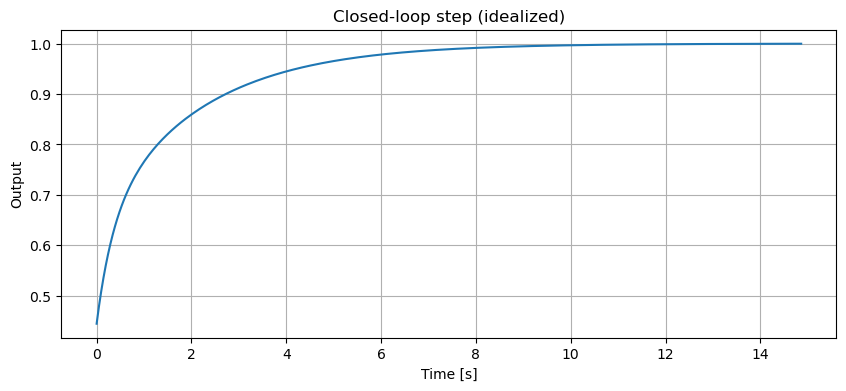

In [9]:
try:
    import control as ct
    Kp, Ki, Kd = 2.0, 1.2, 0.4
    K, tau = 1.0, 0.5
    G = ct.tf([K], [tau, 1])

    # Ideal PID (no filter) for a quick view
    s = ct.tf([1, 0], [1])          # Laplace variable
    C = Kp + Ki/s + Kd*s

    L = C*G
    T = ct.feedback(L, 1)

    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,4))
    ct.bode_plot(L, dB=True)
    plt.suptitle("Open-loop Bode C*G")
    plt.show()

    t, y = ct.step_response(T)
    plt.figure(figsize=(10,4))
    plt.plot(t, y)
    plt.title("Closed-loop step (idealized)")
    plt.grid(True)
    plt.xlabel("Time [s]")
    plt.ylabel("Output")
    plt.show()
except Exception as e:
    print("python-control not available; install 'control' (pip) or 'python-control' (conda-forge) to run this cell.")
    print("Error:", e)